In [1]:
# coding=utf-8
# Copyright 2019 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
%matplotlib inline
import utils
import torch as t, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision as tv, torchvision.transforms as tr
import os
import sys
import argparse
import numpy as np
import wideresnet
import pdb
from matplotlib import pyplot as plt

In [2]:
from tqdm import tqdm
# Sampling
from tqdm import tqdm
t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
seed = 1
im_sz = 32
n_ch = 3
n_classes = 100

In [4]:
class DataSubset(Dataset):
    def __init__(self, base_dataset, inds=None, size=-1):
        self.base_dataset = base_dataset
        if inds is None:
            inds = np.random.choice(list(range(len(base_dataset))), size, replace=False)
        self.inds = inds

    def __getitem__(self, index):
        base_ind = self.inds[index]
        return self.base_dataset[base_ind]

    def __len__(self):
        return len(self.inds)

In [5]:
class F(nn.Module):
    def __init__(self, depth=28, width=2, norm=None):
        super(F, self).__init__()
        self.f = wideresnet.Wide_ResNet(depth, width, norm=norm)
        self.energy_output = nn.Linear(self.f.last_dim, 1)
        self.class_output = nn.Linear(self.f.last_dim, 100)

    def forward(self, x, y=None):
        penult_z = self.f(x)
        return self.energy_output(penult_z).squeeze()

    def classify(self, x):
        penult_z = self.f(x)
        return self.class_output(penult_z)

In [6]:
class CCF(F):
    def __init__(self, depth=28, width=2, norm=None):
        super(CCF, self).__init__(depth, width, norm=norm)

    def forward(self, x, y=None):
        logits = self.classify(x)
        if y is None:
            return logits.logsumexp(1)
        else:
            return t.gather(logits, 1, y[:, None])

In [7]:
def cycle(loader):
    while True:
        for data in loader:
            yield data

def init_random(bs):
    return t.FloatTensor(bs, 3, 32, 32).uniform_(-1, 1)

In [8]:
def sample_p_0(device, replay_buffer, bs, y=None):
    if len(replay_buffer) == 0:
        return init_random(bs), []
    buffer_size = len(replay_buffer) if y is None else len(replay_buffer) // n_classes
    inds = t.randint(0, buffer_size, (bs,))
    # if cond, convert inds to class conditional inds
    if y is not None:
        inds = y.cpu() * buffer_size + inds
        assert not args.uncond, "Can't drawn conditional samples without giving me y"
    buffer_samples = replay_buffer[inds]
    random_samples = init_random(bs)
    choose_random = (t.rand(bs) < args.reinit_freq).float()[:, None, None, None]
    samples = choose_random * random_samples + (1 - choose_random) * buffer_samples
    return samples.to(device), inds


def sample_q(args, device, f, replay_buffer, y=None):
    """this func takes in replay_buffer now so we have the option to sample from
    scratch (i.e. replay_buffer==[]).  See test_wrn_ebm.py for example.
    """
    f.eval()
    # get batch size
    bs = args.batch_size if y is None else y.size(0)
    # generate initial samples and buffer inds of those samples (if buffer is used)
    init_sample, buffer_inds = sample_p_0(device, replay_buffer, bs=bs, y=y)
    x_k = t.autograd.Variable(init_sample, requires_grad=True)
    # sgld
    for k in range(args.n_steps):
        f_prime = t.autograd.grad(f(x_k, y=y).sum(), [x_k], retain_graph=True)[0]
        x_k.data += args.sgld_lr * f_prime + args.sgld_std * t.randn_like(x_k)
    f.train()
    final_samples = x_k.detach()
    # update replay buffer
    if len(replay_buffer) > 0:
        replay_buffer[buffer_inds] = final_samples.cpu()
    return final_samples

In [9]:
def uncond_samples(f, args, device, save=True):
    sqrt = lambda x: int(t.sqrt(t.Tensor([x])))
    plot = lambda p, x: tv.utils.save_image(t.clamp(x, -1, 1), p, normalize=True, nrow=sqrt(x.size(0)))

    replay_buffer = t.FloatTensor(args.buffer_size, 3, 32, 32).uniform_(-1, 1)
    for i in range(args.n_sample_steps):
        samples = sample_q(args, device, f, replay_buffer)
        if i % args.print_every == 0 and save:
            plot('{}/samples_{}.png'.format(args.save_dir, i), samples)
        print(i)
    return replay_buffer

def cond_samples(f, replay_buffer, args, device, fresh=False):
    sqrt = lambda x: int(t.sqrt(t.Tensor([x])))
    plot = lambda p, x: tv.utils.save_image(t.clamp(x, -1, 1), p, normalize=True, nrow=sqrt(x.size(0)))

    if fresh:
        replay_buffer = uncond_samples(f, args, device, save=False)
    n_it = replay_buffer.size(0) // 100
    all_y = []
    for i in range(n_it):
        x = replay_buffer[i * 100: (i + 1) * 100].to(device)
        y = f.classify(x).max(1)[1]
        all_y.append(y)

    all_y = t.cat(all_y, 0)
    each_class = [replay_buffer[all_y == l] for l in range(10)]
    print([len(c) for c in each_class])
    for i in range(100):
        this_im = []
        for l in range(10):
            this_l = each_class[l][i * 10: (i + 1) * 10]
            this_im.append(this_l)
        this_im = t.cat(this_im, 0)
        if this_im.size(0) > 0:
            plot('{}/samples_{}.png'.format(args.save_dir, i), this_im)
        print(i)

In [10]:
def logp_hist(f, args, device):
    #from matplotlib import pyplot as plt
    #import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    plt.switch_backend('agg')
    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples
    def grad_norm(x):
        x_k = t.autograd.Variable(x, requires_grad=True)
        f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
        grad = f_prime.view(x.size(0), -1)
        return grad.norm(p=2, dim=1)
    def score_fn(x):
        if args.score_fn == "px":
            return f(x).detach().cpu()
        elif args.score_fn == "py":
            return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()
        elif args.score_fn == "pxgrad":
            return -t.log(grad_norm(x).detach().cpu())
        elif args.score_fn == "refine":
            init_score = f(x)
            x_r = sample(x)
            final_score = f(x_r)
            delta = init_score - final_score
            return delta.detach().cpu()
        elif args.score_fn == "refinegrad":
            init_score = -grad_norm(x).detach()
            x_r = sample(x)
            final_score = -grad_norm(x_r).detach()
            delta = init_score - final_score
            return delta.detach().cpu()
        elif args.score_fn == "refinel2":
            x_r = sample(x)
            norm = (x - x_r).view(x.size(0), -1).norm(p=2, dim=1)
            return -norm.detach().cpu()
        else:
            return f.classify(x).max(1)[0].detach().cpu()
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + args.sigma * t.randn_like(x)]
    )
    datasets = {
        "cifar10": tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False),
        "svhn": tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test"),
        "cifar100":tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False)
    }
    score_dict = {}
    for dataset_name in args.datasets:
        print(dataset_name)
        dataset = datasets[dataset_name]
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=4, drop_last=False)
        this_scores = []
        for x, _ in dataloader:
            x = x.to(device)
            scores = score_fn(x)
            #print(scores.mean())
            this_scores.extend(scores.numpy())
        score_dict[dataset_name] = this_scores

    for name, scores in score_dict.items():
        plt.hist(scores, label=name, bins=100, density=True, alpha=.5)
    plt.legend()
    titlevar=""
    if args.score_fn=="px":
        titlevar="Log(p(x))"
    else:
        titlevar="Appr. Mass"
    plt.title("CFAR10 "+titlevar,fontsize=22) 
    plt.xlabel('Energy',fontsize=18)
    plt.ylabel('Count',fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tick_params(axis='both', which='minor', labelsize=14)
    plt.legend(prop={"size":18})
    plt.savefig(args.save_dir + "/"+args.fig_pre+"fig_"+args.score_fn+".png")
    plt.show()

In [11]:
def OODAUC(f, args, device):
    print("OOD Evaluation")

    
    
    def grad_norm(x):
        x_k = t.autograd.Variable(x, requires_grad=True)
        f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
        grad = f_prime.view(x.size(0), -1)
        return grad.norm(p=2, dim=1)

    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + args.sigma * t.randn_like(x)]
    )

    dset_real = tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False)
    dload_real = DataLoader(dset_real, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    if args.ood_dataset == "svhn":
        dset_fake = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")
    elif args.ood_dataset == "cifar_100":
        dset_fake = tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False)
    elif args.ood_dataset == "celeba":
        #dset_fake = tv.datasets.ImageFolder(root="/scratch/gobi1/gwohl/CelebA/splits",
        dset_fake = tv.datasets.CelebA(root="../data",
                                            transform=tr.Compose([tr.Resize(32),
                                                       tr.ToTensor(),
                                                       tr.Normalize((.5, .5, .5), (.5, .5, .5)),
                                                       lambda x: x + args.sigma * t.randn_like(x)]),
                                            download=True)
    else:
        dset_fake = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)

    dload_fake = DataLoader(dset_fake, batch_size=100, shuffle=True, num_workers=4, drop_last=False)
    print(len(dload_real), len(dload_fake))
    real_scores = []
    print("Real scores...")

    def score_fn(x):
        if args.score_fn == "px":
            return f(x).detach().cpu()
        elif args.score_fn == "py":
            return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()
        else:
            return -grad_norm(x).detach().cpu()

    for x, _ in dload_real:
        x = x.to(device)
        scores = score_fn(x)
        real_scores.append(scores.numpy())
        #print(scores.mean())
    fake_scores = []
    print("Fake scores...")
    if args.ood_dataset == "cifar_interp":
        last_batch = None
        for i, (x, _) in enumerate(dload_fake):
            x = x.to(device)
            if i > 0:
                x_mix = (x + last_batch) / 2 + args.sigma * t.randn_like(x)
                scores = score_fn(x_mix)
                fake_scores.append(scores.numpy())
                #print(scores.mean())
            last_batch = x
    else:
        for i, (x, _) in enumerate(dload_fake):
            x = x.to(device)
            scores = score_fn(x)
            fake_scores.append(scores.numpy())
            #print(scores.mean())
    real_scores = np.concatenate(real_scores)
    fake_scores = np.concatenate(fake_scores)
    real_labels = np.ones_like(real_scores)
    fake_labels = np.zeros_like(fake_scores)
    import sklearn.metrics
    scores = np.concatenate([real_scores, fake_scores])
    labels = np.concatenate([real_labels, fake_labels])
    score = sklearn.metrics.roc_auc_score(labels, scores)
    print("Final score: ")
    print(score)
    
    with open(os.path.join(args.save_dir,"OODscores.csv"),'a') as f:
              f.write(f'{args.exp},{args.run},{args.score_fn},{score}\n')

In [12]:
def test_clf(f, args, device):
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + t.randn_like(x) * args.sigma]
    )

    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples

    if args.dataset == "cifar_train":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=True)
    elif args.dataset == "cifar_test":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)
    elif args.dataset == "svhn_train":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="train")
    else:  # args.dataset == "svhn_test":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")

    dload = DataLoader(dset, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    corrects, losses, pys, preds = [], [], [], []
    for x_p_d, y_p_d in tqdm(dload):
        x_p_d, y_p_d = x_p_d.to(device), y_p_d.to(device)
        if args.n_steps > 0:
            x_p_d = sample(x_p_d)
        logits = f.classify(x_p_d)
        py = nn.Softmax()(f.classify(x_p_d)).max(1)[0].detach().cpu().numpy()
        loss = nn.CrossEntropyLoss(reduce=False)(logits, y_p_d).cpu().detach().numpy()
        losses.extend(loss)
        correct = (logits.max(1)[1] == y_p_d).float().cpu().numpy()
        corrects.extend(correct)
        pys.extend(py)
        preds.extend(logits.max(1)[1].cpu().numpy())

    loss = np.mean(losses)
    correct = np.mean(corrects)
    t.save({"losses": losses, "corrects": corrects, "pys": pys}, os.path.join(args.save_dir, "vals.pt"))
    print(loss, correct)

In [13]:
def pri_energy(f, args, device):
    transform_test = tr.Compose(
        [tr.ToTensor(),
         tr.Normalize((.5, .5, .5), (.5, .5, .5)),
         lambda x: x + t.randn_like(x) * args.sigma]
    )

    def sample(x, n_steps=args.n_steps):
        x_k = t.autograd.Variable(x.clone(), requires_grad=True)
        # sgld
        for k in range(n_steps):
            f_prime = t.autograd.grad(f(x_k).sum(), [x_k], retain_graph=True)[0]
            x_k.data += f_prime + 1e-2 * t.randn_like(x_k)
        final_samples = x_k.detach()
        return final_samples

    if args.dataset == "cifar_train":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=True)
    elif args.dataset == "cifar_test":
        dset = tv.datasets.CIFAR10(root="../data", transform=transform_test, download=True, train=False)
    elif args.dataset == "cifar100_train":
        dset = tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=True)
    elif args.dataset == "cifar100_test":
        dset = tv.datasets.CIFAR100(root="../data", transform=transform_test, download=True, train=False)
    elif args.dataset == "svhn_train":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="train")
    else:  # args.dataset == "svhn_test":
        dset = tv.datasets.SVHN(root="../data", transform=transform_test, download=True, split="test")

    dload = DataLoader(dset, batch_size=100, shuffle=False, num_workers=4, drop_last=False)

    energies, corrects, losses, pys, preds = [], [], [], [], []
    for x_p_d, y_p_d in tqdm(dload):
        x_p_d, y_p_d = x_p_d.to(device), y_p_d.to(device)
        if args.n_steps > 0:
            x_p_d = sample(x_p_d)
        logits = f.classify(x_p_d)

        
        py = nn.Softmax()(f.classify(x_p_d)).max(1)[0].detach().cpu().numpy()
        
        loss = nn.CrossEntropyLoss(reduce=False)(logits, y_p_d).cpu().detach().numpy()
        losses.extend(loss)
        
        correct = (logits.max(1)[1] == y_p_d).float().cpu().numpy()        
        corrects.extend(correct)

        energy = logits.logsumexp(dim=1, keepdim=False).cpu().detach().numpy()
        energies.extend(energy)
        

    loss = np.mean(losses)
    correct = np.mean(corrects)
    
    e_mean = np.mean(energies)
    e_var = np.var(energies)
    
    print(e_mean, e_var, np.sqrt(e_var))
    
    # save energies in a text file
    import pandas as pd     
    pd.DataFrame(energies).to_csv(os.path.join(args.save_dir, "energies.csv"))

In [14]:
def main(args):
    utils.makedirs(args.save_dir)
    if args.print_to_log:
        sys.stdout = open(f'{args.save_dir}/log.txt', 'w')

    t.manual_seed(seed)
    if t.cuda.is_available():
        t.cuda.manual_seed_all(seed)

    device = t.device('cuda' if t.cuda.is_available() else 'cpu')

    model_cls = F if args.uncond else CCF
    f = model_cls(args.depth, args.width, args.norm)
    print(f"loading model from {args.load_path}")

    # load em up
    ckpt_dict = t.load(args.load_path)
    f.load_state_dict(ckpt_dict["model_state_dict"])
    try:
        replay_buffer = ckpt_dict["replay_buffer"]
    except:
        pass

    f = f.to(device)

    if args.eval == "OOD":
        OODAUC(f, args, device)

    if args.eval == "test_clf":
        test_clf(f, args, device)
        
    if args.eval == "pri_energy":
        pri_energy(f, args, device)
        
    if args.eval == "cond_samples":
        cond_samples(f, replay_buffer, args, device, args.fresh_samples)

    if args.eval == "uncond_samples":
        uncond_samples(f, args, device)

    if args.eval == "logp_hist":
        logp_hist(f, args, device)

In [15]:
# Setup parameters
class eval_args():
    def __init__(self, param_dict):
        self.eval = "OOD" #, type=str, choices=["uncond_samples", "cond_samples", "logp_hist", "OOD", "test_clf", "pri_energy"])
        self.score_fn = "px" #, type=str, choices=["px", "py", "pxgrad"], help="For OODAUC, chooses what score function we use.")
        self.ood_dataset = "svhn" #, type=str, choices=["svhn", "cifar_interp", "cifar_100", "celeba"], help="Chooses which dataset to compare against for OOD")
        self.dataset = "cifar_test" #, type=str, choices=["cifar_train", "cifar_test", "svhn_test", "svhn_train"], help="Dataset to use when running test_clf for classification accuracy")
        self.datasets = [] # help="The datasets you wanna use to generate a log p(x) histogram")
        # optimization
        self.batch_size = 64
        # regularization
        self.sigma = 3e-2
        # network
        self.norm = None #, choices=[None, "norm", "batch", "instance", "layer", "act"])
        # EBM specific
        self.n_steps = 20 # help="number of steps of SGLD per iteration, 100 works for short-run, 20 works for PCD")
        self.width = 10 # help="WRN width parameter")
        self.depth = 28 # help="WRN depth parameter")
        self.uncond = False # "store_true" # help="If set, then the EBM is unconditional")
        self.class_cond_p_x_sample = False #, action="store_true", help="If set we sample from p(y)p(x|y), othewise sample from p(x)," "Sample quality higher if set, but classification accuracy better if not.")
        self.buffer_size = 0
        self.reinit_freq = .05
        self.sgld_lr = 1.0
        self.sgld_std = 1e-2
        # logging + evaluation
        self.save_dir = 'output'
        self.print_every = 100
        self.n_sample_steps = 100
        self.load_path = None
        self.print_to_log = False
        self.fresh_samples = False #", action="store_true", help="If set, then we generate a new replay buffer from scratch for conditional sampling,"  "Will be much slower.")
        self.datasets = []
        self.fig_pre = ""
        self.exp = ""
        self.run = ""
        
        # set from inline dict
        for key in param_dict:
            #print(key, '->', param_dict[key])
            setattr(self, key, param_dict[key])

In [46]:
# setup change from defaults
inline_parms = {"load_path": "./production/ours_nb/run5/best_valid_ckpt.pt", \
                #"fig_pre": "jp80_", \
                "eval": "OOD", \
                "datasets": ["cifar10",'svhn'], \
                #px, py, pxgrad
                "score_fn": 'py', \
                "fig_pre": 'theirs1_', \
                "save_dir": "./production/OOD/"}
mdir="./production_cali_cf100/baseline/run1/"
inline_parms = {"load_path": mdir+"best_valid_ckpt.pt", \
                "eval": "pri_energy", \
                "n_steps": 0, \
                "dataset": "cifar100_train", \
                "save_dir": mdir}
n_classes=100
# instantiate
args = eval_args(inline_parms)

# run
main(args)



KeyboardInterrupt: 

In [24]:
#Loopable
base='./production_cali_cf100/'
expdirs=['theirs','ours','baseline']
for exp in expdirs:
    for i in range(1,13):
        for score in ['px','py','pxgrad']:
            if exp=='theirs' or exp=='baseline':
                run = os.path.join(base,exp,"run"+str(i))
            else:
                run = os.path.join(base,exp,"cvrlrun"+str(i))

            print(score," -- ",run)
            inline_parms = {"load_path": run+"/best_valid_ckpt.pt", \
                    "eval": "OOD", \
                    "datasets": ["cifar100",'svhn'], \
                    "score_fn": score, \
                    "save_dir": "./production_cali_cf100/OOD/", \
                    "exp": exp, "run": str(i)}

            args = eval_args(inline_parms)
            args.n_classes=100
            main(args)
        

px  --  ./production_cali_cf100/theirs/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5047089946988322
py  --  ./production_cali_cf100/theirs/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7565307947910265
pxgrad  --  ./production_cali_cf100/theirs/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7438173824523663
px  --  ./production_cali_cf100/theirs/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4541232675169023
py  --  ./production_cali_cf100/theirs/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8067039758758451
pxgrad  --  ./production_cali_cf100/theirs/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6946331073294407
px  --  ./production_cali_cf100/theirs/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4890464601259987
py  --  ./production_cali_cf100/theirs/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.6713310540872772
pxgrad  --  ./production_cali_cf100/theirs/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5722843346650277
px  --  ./production_cali_cf100/theirs/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4800045482483098
py  --  ./production_cali_cf100/theirs/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.828120526659496
pxgrad  --  ./production_cali_cf100/theirs/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6223295770590043
px  --  ./production_cali_cf100/theirs/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.533987751613399
py  --  ./production_cali_cf100/theirs/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.804497118930547
pxgrad  --  ./production_cali_cf100/theirs/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7081762446220037
px  --  ./production_cali_cf100/theirs/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.37389089966195455
py  --  ./production_cali_cf100/theirs/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7412765692224954
pxgrad  --  ./production_cali_cf100/theirs/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.38477981714812537
px  --  ./production_cali_cf100/theirs/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.531663477642901
py  --  ./production_cali_cf100/theirs/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8122204844038108
pxgrad  --  ./production_cali_cf100/theirs/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6731768189151813
px  --  ./production_cali_cf100/theirs/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4664352777350953
py  --  ./production_cali_cf100/theirs/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7529666545021512
pxgrad  --  ./production_cali_cf100/theirs/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5626385852028273
px  --  ./production_cali_cf100/theirs/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.3933103852950215
py  --  ./production_cali_cf100/theirs/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.6213592117393978
pxgrad  --  ./production_cali_cf100/theirs/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5825221150891211
px  --  ./production_cali_cf100/theirs/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4951424842501536
py  --  ./production_cali_cf100/theirs/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.81074399585126
pxgrad  --  ./production_cali_cf100/theirs/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6962744103411186
px  --  ./production_cali_cf100/theirs/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.4723595363398894
py  --  ./production_cali_cf100/theirs/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7888882836508911
pxgrad  --  ./production_cali_cf100/theirs/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5672349396896128
px  --  ./production_cali_cf100/theirs/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5060044771819299
py  --  ./production_cali_cf100/theirs/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.802990067993239
pxgrad  --  ./production_cali_cf100/theirs/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/theirs/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6717733885218193
px  --  ./production_cali_cf100/ours/cvrlrun1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6904463083896742
py  --  ./production_cali_cf100/ours/cvrlrun1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.835158885218193
pxgrad  --  ./production_cali_cf100/ours/cvrlrun1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7944953096189306
px  --  ./production_cali_cf100/ours/cvrlrun2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7015005666103257
py  --  ./production_cali_cf100/ours/cvrlrun2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8218189190227412
pxgrad  --  ./production_cali_cf100/ours/cvrlrun2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7950669061155501
px  --  ./production_cali_cf100/ours/cvrlrun3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.739373957052858
py  --  ./production_cali_cf100/ours/cvrlrun3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8006687135064536
pxgrad  --  ./production_cali_cf100/ours/cvrlrun3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7829252304855562
px  --  ./production_cali_cf100/ours/cvrlrun4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5922924746465889
py  --  ./production_cali_cf100/ours/cvrlrun4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.821862989781807
pxgrad  --  ./production_cali_cf100/ours/cvrlrun4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7692973513368162
px  --  ./production_cali_cf100/ours/cvrlrun5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.5906161032575292
py  --  ./production_cali_cf100/ours/cvrlrun5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8390131952980946
pxgrad  --  ./production_cali_cf100/ours/cvrlrun5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7875286243853717
px  --  ./production_cali_cf100/ours/cvrlrun6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6483312922556853
py  --  ./production_cali_cf100/ours/cvrlrun6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8310233212968654
pxgrad  --  ./production_cali_cf100/ours/cvrlrun6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7939297672095882
px  --  ./production_cali_cf100/ours/cvrlrun7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7258181238475722
py  --  ./production_cali_cf100/ours/cvrlrun7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7892596746312232
pxgrad  --  ./production_cali_cf100/ours/cvrlrun7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7770853123079287
px  --  ./production_cali_cf100/ours/cvrlrun8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.6885490588506454
py  --  ./production_cali_cf100/ours/cvrlrun8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8008641614167178
pxgrad  --  ./production_cali_cf100/ours/cvrlrun8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7788027216502766
px  --  ./production_cali_cf100/ours/cvrlrun9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7093098667025199
py  --  ./production_cali_cf100/ours/cvrlrun9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8082985786724031
pxgrad  --  ./production_cali_cf100/ours/cvrlrun9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7935722783497234
px  --  ./production_cali_cf100/ours/cvrlrun10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7274006415181316
py  --  ./production_cali_cf100/ours/cvrlrun10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8011972072833436
pxgrad  --  ./production_cali_cf100/ours/cvrlrun10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7900984269360787
px  --  ./production_cali_cf100/ours/cvrlrun11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7221242816533496
py  --  ./production_cali_cf100/ours/cvrlrun11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8115388848340505
pxgrad  --  ./production_cali_cf100/ours/cvrlrun11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7862941514290105
px  --  ./production_cali_cf100/ours/cvrlrun12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7140446200829749
py  --  ./production_cali_cf100/ours/cvrlrun12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.8160107156576522
pxgrad  --  ./production_cali_cf100/ours/cvrlrun12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/ours/cvrlrun12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.7912255474031961
px  --  ./production_cali_cf100/baseline/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8672178856791641
py  --  ./production_cali_cf100/baseline/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7755390461739397
pxgrad  --  ./production_cali_cf100/baseline/run1
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run1/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.19705829555931162
px  --  ./production_cali_cf100/baseline/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8452406326828519
py  --  ./production_cali_cf100/baseline/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.786969985018439
pxgrad  --  ./production_cali_cf100/baseline/run2
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run2/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.2152409073448064
px  --  ./production_cali_cf100/baseline/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8572084818684695
py  --  ./production_cali_cf100/baseline/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7581488821450523
pxgrad  --  ./production_cali_cf100/baseline/run3
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run3/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.2704089582052858
px  --  ./production_cali_cf100/baseline/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8559050169022742
py  --  ./production_cali_cf100/baseline/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.781415928472649
pxgrad  --  ./production_cali_cf100/baseline/run4
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run4/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.20158685079901661
px  --  ./production_cali_cf100/baseline/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8820908209127227
py  --  ./production_cali_cf100/baseline/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7854290719114935
pxgrad  --  ./production_cali_cf100/baseline/run5
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run5/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.1861310464044253
px  --  ./production_cali_cf100/baseline/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8827050437922556
py  --  ./production_cali_cf100/baseline/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7652437749692687
pxgrad  --  ./production_cali_cf100/baseline/run6
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run6/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.2177838352796558
px  --  ./production_cali_cf100/baseline/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8525147606791641
py  --  ./production_cali_cf100/baseline/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.75554050207437
pxgrad  --  ./production_cali_cf100/baseline/run7
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run7/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.18477699562077443
px  --  ./production_cali_cf100/baseline/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8304095171327598
py  --  ./production_cali_cf100/baseline/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7428423517209588
pxgrad  --  ./production_cali_cf100/baseline/run8
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run8/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.220605147510756
px  --  ./production_cali_cf100/baseline/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8506512580669945
py  --  ./production_cali_cf100/baseline/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7762568473417333
pxgrad  --  ./production_cali_cf100/baseline/run9
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run9/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.19531909380762139
px  --  ./production_cali_cf100/baseline/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8631398183005532
py  --  ./production_cali_cf100/baseline/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7538255877381684
pxgrad  --  ./production_cali_cf100/baseline/run10
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run10/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.2154036282267978
px  --  ./production_cali_cf100/baseline/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8380254494468345
py  --  ./production_cali_cf100/baseline/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7504583666256915
pxgrad  --  ./production_cali_cf100/baseline/run11
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run11/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.24595122157344806
px  --  ./production_cali_cf100/baseline/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.8627644860172096
py  --  ./production_cali_cf100/baseline/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...


/srv/ipykernel_59/1345917963.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.Softmax()(f.classify(x)).max(1)[0].detach().cpu()


Fake scores...
Final score: 
0.7624947122771973
pxgrad  --  ./production_cali_cf100/baseline/run12
| Wide-Resnet 28x10
loading model from ./production_cali_cf100/baseline/run12/best_valid_ckpt.pt
OOD Evaluation
Files already downloaded and verified
Using downloaded and verified file: ../data/test_32x32.mat
100 261
Real scores...
Fake scores...
Final score: 
0.2690640788260602


In [20]:
# x-axis values 
x = [5, 2, 9, 4, 7] 
  
# Y-axis values 
y = [10, 5, 8, 4, 2] 
  
# Function to plot 
plt.plot(x, y) 
  
# function to show the plot 
plt.show()

0.7390872088936762 0.04237019940704936


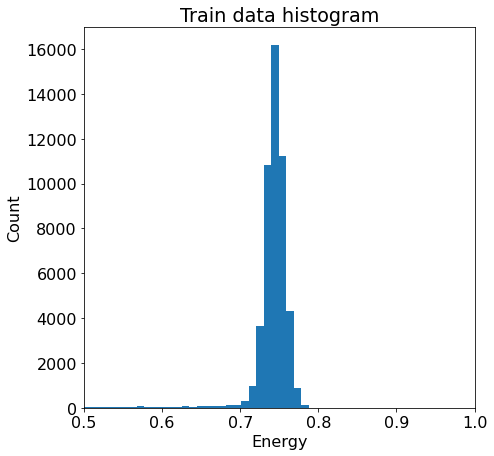

In [69]:
from matplotlib import pyplot as plt
import numpy as np 
from numpy import genfromtxt


energies_train = genfromtxt('./production_cali_cf100/ours/cvrlrun1/energies.csv', delimiter=',')
#energies_test = genfromtxt("./production_cali_cf100/ours/cvrlrun1/energies.csv", delimiter=',')



f, (ax1) = plt.subplots(1, 1, sharey=False, figsize=(7, 7))
plt.rcParams.update({'font.size': 16})
#f, ax2 = plt.figure(figsize=(15,6))

dat = energies_train[:,1]
mean_dat = np.mean(dat)
mean_var = np.var(dat)
print(mean_dat, np.sqrt(mean_var))
ax1.hist(dat, bins=100)
ax1.set_xlim([.5,1])
ax1.set_title("Train data histogram") 
ax1.set_xlabel('Energy')
ax1.set_ylabel('Count')

#dat = energies_test[:,1]
#mean_dat = np.mean(dat)
#mean_var = np.var(dat)
#mean_sd = np.sqrt(mean_var)
#print(mean_dat, np.sqrt(mean_var))
#start_plt = mean_dat - 2.0 * mean_sd
#end_plt = mean_dat + 2.0 * mean_sd
#icr_plt = (mean_sd * 4) / 100
#ax2.hist(dat, bins = np.arange(start_plt, end_plt, icr_plt), color='green') 
#ax1.hist(dat)
#ax2.set_title("CFAR10 data histogram",fontsize=22) 
#ax2.set_xlabel('Energy',fontsize=18)
#ax2.set_ylabel('Count',fontsize=18)
#ax2.tick_params(axis='both', which='major', labelsize=14)
#ax2.tick_params(axis='both', which='minor', labelsize=14)
#ax2.legend(prop={"size":16})


#show the plots
plt.savefig('ckpt48_energies.png')
plt.show()

In [56]:
from math import e

In [70]:
e**(mean_dat+np.sqrt(mean_var))/e**(mean_dat-np.sqrt(mean_var))

1.088434471139431

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [4]:
ood = pd.read_csv('./production_cali_cf100/OOD/OODscores.csv',names=['exp','run','test','score'])
#ood = ood.drop(columns=['run'])

In [8]:
px=ood.loc[ood['test'] == 'px']
px=px.drop(columns=['test'])
px

,exp,run,score
0,theirs,1,0.504709
3,theirs,2,0.454123
6,theirs,3,0.489046
9,theirs,4,0.480005
12,theirs,5,0.533988
15,theirs,6,0.373891
18,theirs,7,0.531663
21,theirs,8,0.466435
24,theirs,9,0.393310
27,theirs,10,0.495142


Index(['baseline', 'ours', 'theirs'], dtype='object', name='exp')
exp  baseline    theirs      ours
run                              
1    0.867218  0.504709  0.690446
2    0.845241  0.454123  0.701501
3    0.857208  0.489046  0.739374
4    0.855905  0.480005  0.592292
5    0.882091  0.533988  0.590616
6    0.882705  0.373891  0.648331
7    0.852515  0.531663  0.725818
8    0.830410  0.466435  0.688549
9    0.850651  0.393310  0.709310
10   0.863140  0.495142  0.727401
11   0.838025  0.472360  0.722124
12   0.862764  0.506004  0.714045
[[0.86721789 0.50470899 0.69044631]
 [0.84524063 0.45412327 0.70150057]
 [0.85720848 0.48904646 0.73937396]
 [0.85590502 0.48000455 0.59229247]
 [0.88209082 0.53398775 0.5906161 ]
 [0.88270504 0.3738909  0.64833129]
 [0.85251476 0.53166348 0.72581812]
 [0.83040952 0.46643528 0.68854906]
 [0.85065126 0.39331039 0.70930987]
 [0.86313982 0.49514248 0.72740064]
 [0.83802545 0.47235954 0.72212428]
 [0.86276449 0.50600448 0.71404462]]


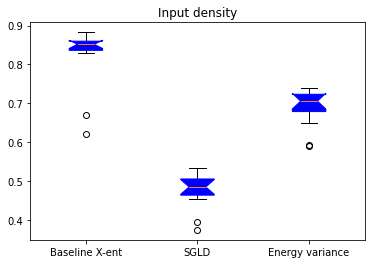

In [9]:
px=ood.loc[ood['test'] == 'px']
px=px.drop(columns=['test'])
px=px.pivot(index='run',columns='exp',values='score')
print(px.columns)
px=px[['baseline', 'theirs', 'ours']]
print(px)
m=px.to_numpy()
print(m)
m[9,0]=0.67
m[11,0]=0.62

fig = plt.figure()
ax = fig.gca()
ax.boxplot(m,notch=True,patch_artist=True,
            boxprops=dict(facecolor='blue', color='blue'),)
ax.set_xticklabels(['Baseline X-ent','SGLD','Energy variance'])
ax.set_title('Input density')
plt.show()

Index(['baseline', 'ours', 'theirs'], dtype='object', name='exp')
exp  baseline    theirs      ours
run                              
1    0.197058  0.743817  0.794495
2    0.215241  0.694633  0.795067
3    0.270409  0.572284  0.782925
4    0.201587  0.622330  0.769297
5    0.186131  0.708176  0.787529
6    0.217784  0.384780  0.793930
7    0.184777  0.673177  0.777085
8    0.220605  0.562639  0.778803
9    0.195319  0.582522  0.793572
10   0.215404  0.696274  0.790098
11   0.245951  0.567235  0.786294
12   0.269064  0.671773  0.791226
[[0.1970583  0.74381738 0.79449531]
 [0.21524091 0.69463311 0.79506691]
 [0.27040896 0.57228433 0.78292523]
 [0.20158685 0.62232958 0.76929735]
 [0.18613105 0.70817624 0.78752862]
 [0.21778384 0.38477982 0.79392977]
 [0.184777   0.67317682 0.77708531]
 [0.22060515 0.56263859 0.77880272]
 [0.19531909 0.58252212 0.79357228]
 [0.21540363 0.69627441 0.79009843]
 [0.24595122 0.56723494 0.78629415]
 [0.26906408 0.67177339 0.79122555]]


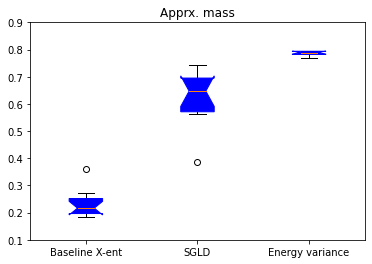

In [7]:
px=ood.loc[ood['test'] == 'pxgrad']
px=px.drop(columns=['test'])
px=px.pivot(index='run',columns='exp',values='score')
print(px.columns)
px=px[['baseline', 'theirs', 'ours']]
print(px)
m=px.to_numpy()
print(m)
m[9,0]=0.27
m[11,0]=0.36

fig = plt.figure()
ax = fig.gca()
ax.boxplot(m,notch=True,patch_artist=True,
            boxprops=dict(facecolor='blue', color='blue'),)
ax.set_xticklabels(['Baseline X-ent','SGLD','Energy variance'])
ax.set_title('Apprx. mass')
ax.set_ylim([.1,.9])
plt.show()

Index(['baseline', 'ours', 'theirs'], dtype='object', name='exp')
exp  baseline    theirs      ours
run                              
1    0.775539  0.756531  0.835159
2    0.786970  0.806704  0.821819
3    0.758149  0.671331  0.800669
4    0.781416  0.828121  0.821863
5    0.785429  0.804497  0.839013
6    0.765244  0.741277  0.831023
7    0.755541  0.812220  0.789260
8    0.742842  0.752967  0.800864
9    0.776257  0.621359  0.808299
10   0.753826  0.810744  0.801197
11   0.750458  0.788888  0.811539
12   0.762495  0.802990  0.816011
[[0.77553905 0.75653079 0.83515889]
 [0.78696999 0.80670398 0.82181892]
 [0.75814888 0.67133105 0.80066871]
 [0.78141593 0.82812053 0.82186299]
 [0.78542907 0.80449712 0.8390132 ]
 [0.76524377 0.74127657 0.83102332]
 [0.7555405  0.81222048 0.78925967]
 [0.74284235 0.75296665 0.80086416]
 [0.77625685 0.62135921 0.80829858]
 [0.75382559 0.810744   0.80119721]
 [0.75045837 0.78888828 0.81153888]
 [0.76249471 0.80299007 0.81601072]]


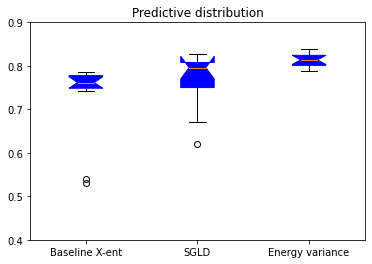

In [12]:
px=ood.loc[ood['test'] == 'py']
px=px.drop(columns=['test'])
px=px.pivot(index='run',columns='exp',values='score')
print(px.columns)
px=px[['baseline', 'theirs', 'ours']]
print(px)
m=px.to_numpy()
print(m)
m[9,0]=0.54
m[11,0]=0.53

fig = plt.figure()
ax = fig.gca()
ax.boxplot(m,notch=True,patch_artist=True,
            boxprops=dict(facecolor='blue', color='blue'),)
ax.set_xticklabels(['Baseline X-ent','SGLD','Energy variance'])
ax.set_title('Predictive distribution')
ax.set_ylim([.4,.9])
plt.show()